# Transfer learning and fine tuning for image classification

## Transfer learning

### Importing the libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
tf.__version__

'2.4.0'

### Loading the images

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Datasets/cat_dog_2.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

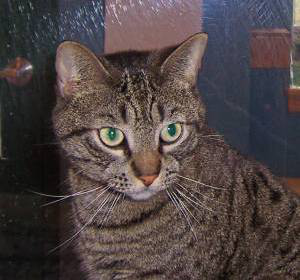

In [ ]:
tf.keras.preprocessing.image.load_img('/content/cat_dog_2/training_set/cat/cat.1.jpg')

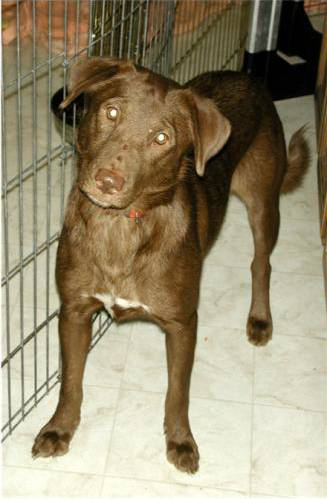

In [ ]:
tf.keras.preprocessing.image.load_img('/content/cat_dog_2/training_set/dog/dog.1.jpg')

### Train and test set

In [ ]:
training_generator = ImageDataGenerator(rescale=1./255,)
train_dataset = training_generator.flow_from_directory('/content/cat_dog_2/training_set',
                                                        target_size = (128, 128),
                                                        batch_size = 128,
                                                        class_mode = 'binary',
                                                        shuffle = True)

Found 4000 images belonging to 2 classes.


In [ ]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('/content/cat_dog_2/test_set',
                                                     target_size = (128, 128),
                                                     batch_size = 1,
                                                     class_mode = 'binary',
                                                     shuffle = False)

Found 1000 images belonging to 2 classes.


### Pre-trained network

In [ ]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False,
                                               input_shape = (128,128,3))

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
len(base_model.layers)

154

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

### Custom dense layer

In [ ]:
head_model = base_model.output
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(1, activation = 'sigmoid')(head_model)

### Building and training the neural network

In [ ]:
network = Model(inputs = base_model.input, outputs = head_model)

In [ ]:
(1280 + 2) / 2

641.0

In [ ]:
network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
network.compile(loss = 'binary_crossentropy', optimizer='Adam',
                metrics = ['accuracy'])

In [ ]:
history = network.fit(train_dataset, epochs=5)

Epoch 1/5
32/32 [==============================] - 19s 315ms/step - loss: 0.5878 - accuracy: 0.7681
Epoch 2/5
32/32 [==============================] - 11s 328ms/step - loss: 0.0798 - accuracy: 0.9696
Epoch 3/5
32/32 [==============================] - 10s 323ms/step - loss: 0.0520 - accuracy: 0.9830
Epoch 4/5
32/32 [==============================] - 10s 324ms/step - loss: 0.0424 - accuracy: 0.9844
Epoch 5/5
32/32 [==============================] - 10s 322ms/step - loss: 0.0192 - accuracy: 0.9942


### Evaluating the neural network

In [ ]:
# Approach 1 (all pixels): 0.50
# Approach 2 (CNN): 0.72
# Approach 3 (Transfer learning): 0.96
network.evaluate(test_dataset)

1000/1000 [==============================] - 7s 6ms/step - loss: 0.1034 - accuracy: 0.9670


[0.10337300598621368, 0.9670000076293945]

## Fine tuning

### Implementing

In [ ]:
base_model.trainable = True

In [ ]:
len(base_model.layers)

154

In [ ]:
fine_tuning_at = 100

In [ ]:
for layer in base_model.layers[:fine_tuning_at]:
  layer.trainable = False

In [ ]:
for layer in base_model.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f1b0390acf8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1b0390acc0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f1b00fe3c88> False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f1b0102fdd8> False
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7f1b00b58470> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f1b00b5a198> False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f1b00b58d30> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1b00b6b048> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f1b00b6bc88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1b00b6e128> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f1b

In [ ]:
network.compile(loss = 'binary_crossentropy', optimizer='Adam', metrics = ['accuracy'])

In [ ]:
history = network.fit(train_dataset, epochs=5)

Epoch 1/5
32/32 [==============================] - 14s 327ms/step - loss: 0.2885 - accuracy: 0.9107
Epoch 2/5
32/32 [==============================] - 11s 331ms/step - loss: 0.0409 - accuracy: 0.9904
Epoch 3/5
32/32 [==============================] - 11s 332ms/step - loss: 0.0853 - accuracy: 0.9714
Epoch 4/5
32/32 [==============================] - 11s 331ms/step - loss: 0.0326 - accuracy: 0.9909
Epoch 5/5
32/32 [==============================] - 11s 328ms/step - loss: 0.0228 - accuracy: 0.9927


### Evaluate

In [ ]:
predictions = network.predict(test_dataset)
predictions

array([[1.00000000e+00],
       [9.99993682e-01],
       [7.80436769e-03],
       [1.00000000e+00],
       [3.09401786e-23],
       [1.20572830e-02],
       [2.04110555e-02],
       [9.94780362e-01],
       [1.11617828e-05],
       [9.37636375e-01],
       [1.16517751e-31],
       [4.49891453e-14],
       [6.79840025e-22],
       [3.31409806e-14],
       [5.78552090e-07],
       [1.00000000e+00],
       [1.00000000e+00],
       [2.94140295e-10],
       [2.10968028e-05],
       [1.51293111e-08],
       [9.63357587e-31],
       [1.79500300e-15],
       [1.00000000e+00],
       [2.78770229e-10],
       [2.58203137e-14],
       [1.29054794e-13],
       [9.44994002e-14],
       [1.00000000e+00],
       [2.10231144e-09],
       [9.99556005e-01],
       [3.14589030e-08],
       [1.00000000e+00],
       [1.00000000e+00],
       [2.10496115e-15],
       [9.99974012e-01],
       [1.00000000e+00],
       [9.99970913e-01],
       [4.21233753e-17],
       [9.99996781e-01],
       [2.12984920e-01],


In [ ]:
predictions = (predictions > 0.5)
predictions

array([[ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [

In [ ]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
# Approach 1 (all pixels): 0.50
# Approach 2 (CNN): 0.72
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)

0.806

In [ ]:
network.evaluate(test_dataset)

1000/1000 [==============================] - 7s 7ms/step - loss: 4.0121 - accuracy: 0.8060


[4.012067794799805, 0.8059999942779541]